# K-Means Clustering to Identify Zones based on Polar Bear Location for Downstream Machine Learning on Den Location

### The dataset "data/polarbears/pB_2009_2016.csv" contains robust latitude and longitudinal data of polar bears every 30 minutes from 2009 - 2016.

#### Machine Learning Pipeline Overview
1. Import and clean the dataset -- remove null values, select relevant columns, remove outliers
2. Plot coordinates onto a map for visualizing "zones" or k clusters
3. Select k based on a high score with useful resolution for locating polar bears across a massive surface area.
4. Create, train and fit the model based on k clusters using the 2009-2016 dataset
5. Apply our model to the 1985-2016 polar bear dataset for final machine learning algorithms

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import plotly.express as px
import time 
import matplotlib.cm as cm
import glob
from PIL import Image

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Import and Clean the Data Set

In [4]:
#Import Dataset
df = pd.read_csv('../../../data/polarbears/pB_2009_2016.csv')

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342315 entries, 0 to 342314
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bear_id       342315 non-null  object 
 1   GMTdate       342315 non-null  object 
 2   GMTtime       342315 non-null  object 
 3   long          342315 non-null  float64
 4   lat           342315 non-null  float64
 5   raw_act       342315 non-null  float64
 6   standard_act  342315 non-null  float64
 7   active_den    342315 non-null  int64  
 8   habitat       342315 non-null  object 
 9   Unnamed: 9    0 non-null       float64
 10  Unnamed: 10   0 non-null       float64
 11  Unnamed: 11   3034 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 31.3+ MB


In [9]:
#Remove unnamed columns
df = df[['bear_id', 'GMTdate', 'GMTtime', 'long', 'lat', 'raw_act',
       'standard_act', 'active_den', 'habitat']]
#Convert GMTdate to datetime format
df["GMTdate"]=pd.to_datetime(df["GMTdate"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342315 entries, 0 to 342314
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   bear_id       342315 non-null  object        
 1   GMTdate       342315 non-null  datetime64[ns]
 2   GMTtime       342315 non-null  object        
 3   long          342315 non-null  float64       
 4   lat           342315 non-null  float64       
 5   raw_act       342315 non-null  float64       
 6   standard_act  342315 non-null  float64       
 7   active_den    342315 non-null  int64         
 8   habitat       342315 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 23.5+ MB


In [11]:
#Create a DataFrame with latitude and longitude ONLY
df_bear = df[['long', 'lat']].copy()

In [12]:
# Drop lat/longs of extreme outliers below 0.01 percentile or above 99.99 percentile
df_bear_filtered = df_bear[(df_bear.quantile(0.0001) < df_bear) & (df_bear < df_bear.quantile(0.9999))]
df_bear_filtered = df_bear_filtered.dropna(how='any')

print(f'{df_bear.shape[0] - df_bear_filtered.shape[0]} extreme outliers removed')
print(f'Shape of filtered df_pickup: {df_bear_filtered.shape}')

140 extreme outliers removed
Shape of filtered df_pickup: (342175, 2)



## Visualize Clusters on Arctic Circle Map

In [63]:
def plot_geolocation_by_cluster(df,cluster,title,centers,filename):
    
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['long', 'lat'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.long, df.lat)])
    
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_aspect('equal')
    
    # Import ArcticShape Files
    world_full = gpd.read_file("../../../data/shapefiles/arctic_full.shp")
    world_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)
    
    # Plot coordinates from geo_df on top of Arctic Map
    if cluster is not None:
        geo_df.plot(ax=ax, column=cluster, legend = True, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,0], centers[:,1])))
            centers_gseries.plot(ax=ax, alpha=0.8, color='black', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.ylim(50, 90)
#         plt.xlim(-180, -100)
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        plt.legend(loc='lower right')
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.ylim(50, 90)
        plt.show()
        
        
    fig.clf()

In [ ]:
ssd = []

for i in range(2, 16):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(df_bear_filtered)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    df_bear_filtered['cluster'] = km.labels_

    # Plot lat/long and clusters on map
    plot_geolocation_by_cluster(df_bear_filtered, cluster='cluster', title= f'K-Means: Polar Bear Locations grouped into {i} clusters', centers=centers, filename=f'../../../machine_learning/plots/bear_kmeans_{i}_clusters.png')

In [42]:
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    images = glob.glob(f'{path_to_images}')
    
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
    
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)


In [43]:
#Save PNG images
png_to_gif(path_to_images='../../../machine_learning/plots/*.png', 
           save_file_path='../../../machine_learning/plots/bear_kmeans_clusters.gif',
           duration=500)



In [41]:
#Visualize gif in jupyter
from IPython.display import HTML
HTML('<img src="../../../machine_learning/plots/bear_kmeans_clusters.gif">')

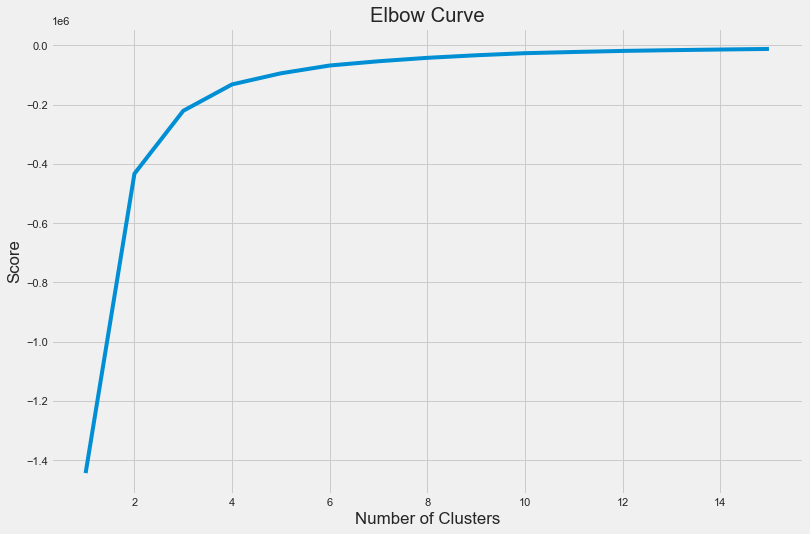

In [44]:
# Run standard Elbow Cuver for KMeans
K_clusters = range(1,16)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df_bear_filtered[['lat']]
X_axis = df_bear_filtered[['long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

plt.show()

## Create KMeans Model for Den Location

In [45]:
km = MiniBatchKMeans(n_clusters=10)
km.fit_predict(df_bear_filtered)

array([4, 4, 4, ..., 1, 1, 1], dtype=int32)

In [46]:
#Save lat/lon labeling model
import pickle
pickle.dump(km, open("../../models/den_loc_km.pkl", "wb"))

In [47]:
with open("../../models/den_loc_km.pkl", "rb") as f:
    model_object = pickle.load(f)
    f.close()

# Transform Data Frame to Match Machine Learning Compile File

In [49]:
df = df.groupby(pd.Grouper(key="GMTdate", freq='M')).mean().reset_index()

In [50]:
df = df[["long", "lat"]].dropna()

### Fit Dataset to Model

In [52]:
km.fit_predict(df)
df["loc_zone"] = km.labels_
df.head()

,long,lat,loc_zone
0,-147.079956,70.518492,8
1,-148.079600,70.881717,8
2,-153.360651,71.689841,2
3,-158.677270,72.884016,5
4,-153.710525,73.217770,2


# Load and Clean1985-2016 Dataset

In [53]:
df2 = pd.read_csv('../../../data/polarbears/pB_1985_2016.csv')

In [54]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263886 entries, 0 to 263885
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BearID_rsf       263886 non-null  int64  
 1   DateTimeUTC_rsf  263886 non-null  object 
 2   latitude_rsf     263886 non-null  float64
 3   longitude_rsf    263886 non-null  float64
 4   season           263886 non-null  object 
 5   period           263886 non-null  int64  
 6   lc94_rsf         263886 non-null  object 
 7   eaInterval_rsf   263886 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 16.1+ MB


In [55]:
df2["DateTimeUTC_rsf"]=pd.to_datetime(df2["DateTimeUTC_rsf"])

In [56]:
df2 = df2.groupby(pd.Grouper(key="DateTimeUTC_rsf", freq='M')).mean().reset_index()

In [57]:
df2 = df2[["longitude_rsf", "latitude_rsf"]]
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 373
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   longitude_rsf  334 non-null    float64
 1   latitude_rsf   334 non-null    float64
dtypes: float64(2)
memory usage: 7.8 KB


# Use Model to Predict Zones

In [58]:
km.fit_predict(df2)
df2["loc_zone"] = km.labels_
df2.head()

,longitude_rsf,latitude_rsf,loc_zone
0,-145.622023,70.686773,5
1,-141.682085,70.557746,7
2,-146.170957,71.341745,5
3,-152.879137,71.677074,9
4,-154.493710,72.594194,9


### Export to CSV

In [59]:
df2.to_csv (r'../../../data/polarbears/latlonzone_1985_2016.csv', index = False, header=True)

In [61]:
df.to_csv (r'../../../data/polarbears/latlonzone_2009_2016.csv', index = False, header=True)